# AmilcalSat raw image sensor processing

This notebook shows how to process the raw image sensor in AmicalSat

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.interpolate

In this notebook we look at raw sensor images of a calibration sheet. The calibration sheet was photographed independently and it is shown below.

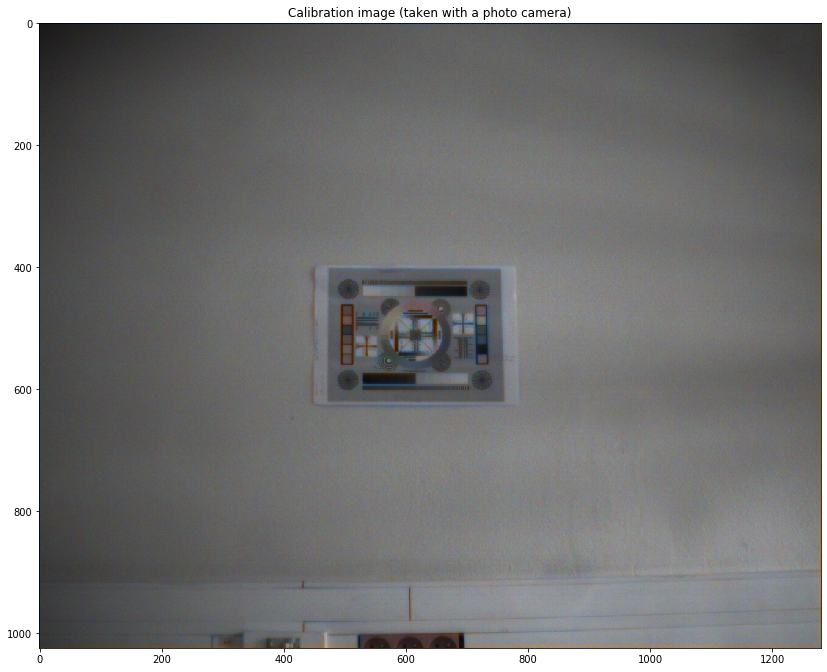

In [2]:
original = plt.imread('2.tiff')
plt.figure(figsize = (14,14), facecolor = 'w')
plt.imshow(original)
plt.title('Calibration image (taken with a photo camera)');

The format of raw images is little-endian 16 bit integers. Only the 10 least-significant bits are used in `N2.raw`, while only the 12 least-significant bits are used in `N3.raw`.

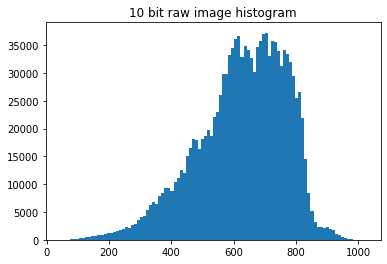

In [3]:
data_10bits = np.fromfile('N2.raw', dtype = 'int16')
plt.hist(data_10bits, bins = 100)
plt.title('10 bit raw image histogram');

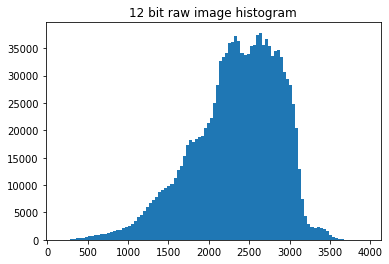

In [4]:
data_12bits = np.fromfile('N3.raw', dtype = 'int16')
plt.hist(data_12bits, bins = 100)
plt.title('12 bit raw image histogram');

The functions below extract the Red, Green, Blue and White pixels, perform interpolation on each channel to the full image resolution, convert RGB values to CbCr, take the White values as Y' and convert Y'CbCr back to RGB.

In [5]:
def get_channel(img, a_off, b_off):
    step = 8
    img_chan = img[a_off::8, b_off::8]
    f = scipy.interpolate.interp2d(np.arange(a_off,img.shape[1],8), np.arange(b_off,img.shape[0],8), img_chan,
                                   kind = 'cubic')
    return f(np.arange(img.shape[1]), np.arange(img.shape[0]))

def get_green_channel(img):
    img_G1 = img[4::8, ::8]
    img_G2 = img[::8, 4::8]
    points1 = np.mgrid[4:img.shape[0]:8, :img.shape[1]:8].reshape((2,-1)).transpose()
    points2 = np.mgrid[:img.shape[0]:8, 4:img.shape[1]:8].reshape((2,-1)).transpose()
    points = np.concatenate((points1, points2))
    img_G = np.concatenate((img_G1.ravel(), img_G2.ravel()))
    a, b = np.mgrid[:img.shape[0], :img.shape[1]]
    return scipy.interpolate.griddata(points, img_G, (a, b), method = 'cubic')

def get_luminance_channel(img):
    img_Y1 = img[1::4, :]
    img_Y2 = img[2::4, :]
    img_Y3 = img[3::4, :]
    img_Y4 = img[:, 1::4]
    img_Y5 = img[:, 2::4]
    img_Y6 = img[:, 3::4]
    points1 = np.mgrid[1:img.shape[0]:4, :img.shape[1]].reshape((2,-1)).transpose()
    points2 = np.mgrid[2:img.shape[0]:4, :img.shape[1]].reshape((2,-1)).transpose()
    points3 = np.mgrid[3:img.shape[0]:4, :img.shape[1]].reshape((2,-1)).transpose()
    points4 = np.mgrid[:img.shape[0], 1:img.shape[1]:4].reshape((2,-1)).transpose()
    points5 = np.mgrid[:img.shape[0], 2:img.shape[1]:4].reshape((2,-1)).transpose()
    points6 = np.mgrid[:img.shape[0], 3:img.shape[1]:4].reshape((2,-1)).transpose()
    points = np.concatenate((points1, points2, points3, points4, points5, points6))
    img_Y = np.concatenate((img_Y1.ravel(), img_Y2.ravel(), img_Y3.ravel(), img_Y4.ravel(),
                            img_Y5.ravel(), img_Y6.ravel()))
    a, b = np.mgrid[:img.shape[0], :img.shape[1]]
    return scipy.interpolate.griddata(points, img_Y, (a, b), method = 'nearest')

def get_RGB(data, nbits):
    ncols = 1280
    img = data[:data.size//ncols*ncols].reshape((-1,ncols)).astype('float')
    # scale to [0,256)
    img *= 2**(8-nbits)

    # It seems that the sensor Bayer filter is
    #  *-----------------*
    #  | B W W W G W W W |
    #  | W W W W W W W W |
    #  | W W W W W W W W |
    #  | G W W W R W W W |
    #  | W W W W W W W W |
    #  | W W W W W W W W |
    #  *-----------------*
    img_B = get_channel(img, 0, 0)
    img_R = get_channel(img, 4, 4)
    img_G = get_green_channel(img)
    img_Y = get_luminance_channel(img)

    # JPEG Y'CbCr conversion
    img_Cb = -0.168736*img_R-0.331264*img_G+0.5*img_B+128
    img_Cr = 0.5*img_R-0.418688*img_G-0.081312*img_B+128
    
    # CbCr translation for white calibration (determined experimentally with calibration image)
    Cb_translation = 14.47
    Cr_translation = -20.96
    img_Cb += Cb_translation
    img_Cr += Cr_translation

    img_R2 = img_Y + 1.402*(img_Cr-128)
    img_G2 = img_Y - 0.344136*(img_Cb-128) - 0.714136*(img_Cr-128)
    img_B2 = img_Y + 1.772*(img_Cb-128)

    img_RGB = np.stack((img_R2, img_G2, img_B2), axis = -1)
    return np.clip(np.round(img_RGB), 0, 255).astype('uint8'), img_Y, img_Cb, img_Cr

In [6]:
img_RGB_12bits = get_RGB(data_12bits, 12)[0]
img_RGB_10bits = get_RGB(data_10bits, 10)[0]

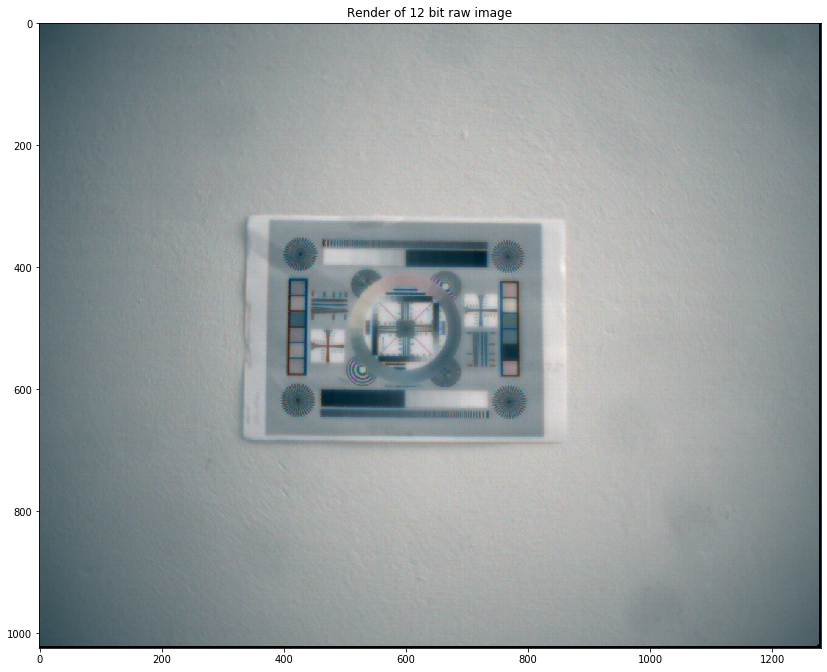

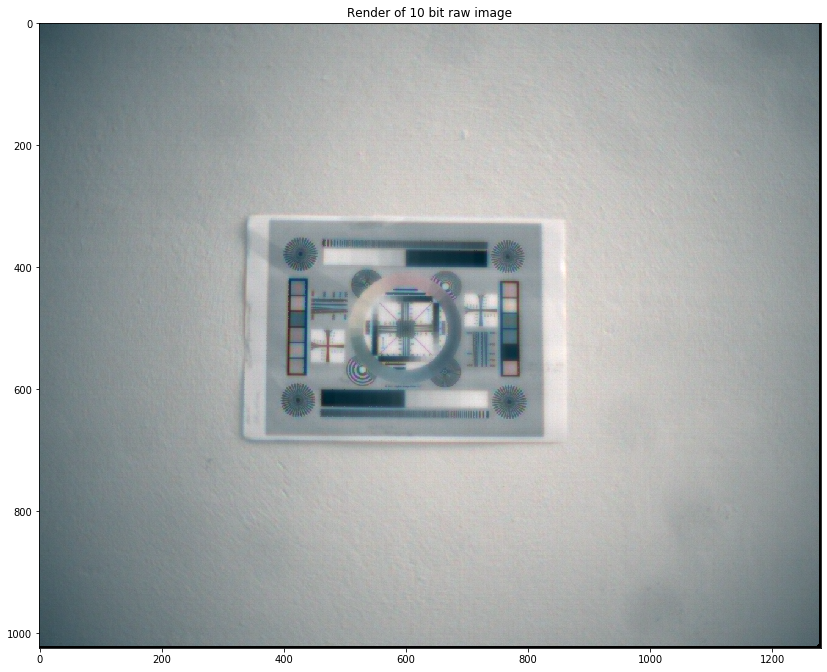

In [7]:
plt.figure(figsize = (14,14))
plt.imshow(img_RGB_12bits)
plt.title('Render of 12 bit raw image')
plt.figure(figsize = (14,14))
plt.imshow(img_RGB_10bits)
plt.title('Render of 10 bit raw image');